In [1]:
from utils.algorithm import overlay_of_subdivision
from utils.data_structures import DCEL
import matplotlib.pyplot as plt

In [2]:
%matplotlib notebook

In [3]:
w = [(1,1), (2,2), (1,3), (0,2)]

v = [(2, 1), (3, 2), (2, 3), (1, 2)]

w_e = [[0, 1], [1, 2], [2, 3], [0, 3]]
v_e = [[0, 1], [1, 2], [2, 3], [0, 3]]

In [8]:
w = [(1,1), (2,2), (1,3), (0,2), (3,1), (4,2), (3,3)]
w_e = [[0, 1], [1, 2], [2, 3], [0, 3], [1,4], [4,5], [5,6], [6,1]]

In [15]:
w = [(1,1), (2,2), (1.5, 2.5), (1,1)]
w_e = [[i, i+1] for i in range(len(w)-1) if i != 4]

v = [(1.5, 1), (2.5, 3), (3,2), (1.5,1)]
v_e = [[i, i+1] for i in range(len(v)-1) if i != 4]

In [44]:
w = [
    (1,1),
    (9,3),
    (14,3),
    (6,8),
    (2,11),
    (6,15),
    (10,13),
    (14,11),
    (11,18),
    (16,18),
    (13,23)
]
w_e = [
    [0, 1],
    [1, 2],
    [1, 3],
    [0, 4],
    [2, 6],
    [3, 4],
    [3, 6],
    [4, 5],
    [7, 6],
    [7, 9],
    [6, 5],
    [6, 8],
    [5, 8],
    [8, 9],
    [8, 10],
    [9, 10]
]

v = [
    (7,1),
    (4,5),
    (11,5),
    (8,9),
    (14,9),
    (6,12),
    (2,15),
    (12, 15),
    (8 , 18),
    (13, 19)
]

v_e = [
    [0,1],
    [0,2],
    [1,2],
    [1,3],
    [2,3],
    [2,4],
    [3,5],
    [4, 7],
    [5,6],
    [6,8],
    [7,9],
    [8,9]
]

In [45]:
# w = list(set(w))

# w_e = list(set([tuple(sorted(x)) for x in w_e]))

# w_e += [[x[1], x[0]] for x in w_e]

# v = list(set(v))

# v_e = list(set([tuple(sorted(x)) for x in v_e]))

# v_e += [[x[1], x[0]] for x in v_e]


S1 = DCEL(w, w_e)
S2 = DCEL(v, v_e)

# S1.build_dcel()
# S2.build_dcel()

<IPython.core.display.Javascript object>


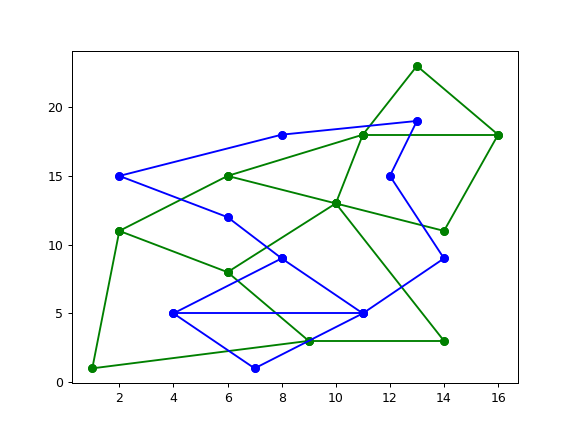

In [46]:
plt.close()
eps = 1e-10

vectors = [
    [eps, eps],
    [eps,-eps],
    [-eps,-eps],
    [-eps,eps]
]

def get_direction_of_line(beg, end):
    return (0 if end[0] - beg[0] > 0 else 2) + (1 if end[1] - beg[1] < 0 else 0)


#Firstly let's get list of lines from Dcel.el and Dcel.vl lists
S1_lines = []
for edge in S1.el:
    v1 = S1.vl[edge[0]]
    v2 = S1.vl[edge[1]]

    if v1 > v2:
        v1, v2 = v2, v1

    vec = vectors[get_direction_of_line(v1, v2)]

    v1 = list(v1)
    v2 = list(v2)

    v1[0] += vec[0]
    v1[1] += vec[1]
    v2[0] -= vec[0]
    v2[1] -= vec[1]

    v1 = tuple(v1)
    v2 = tuple(v2)

    S1_lines.append([v1, v2])

S2_lines = []  
for edge in S2.el:
    v1 = S2.vl[edge[0]]
    v2 = S2.vl[edge[1]]

    if v1 > v2:
        v1, v2 = v2, v1

    vec = vectors[get_direction_of_line(v1, v2)]

    v1 = list(v1)
    v2 = list(v2)

    v1[0] += vec[0]
    v1[1] += vec[1]
    v2[0] -= vec[0]
    v2[1] -= vec[1]

    v1 = tuple(v1)
    v2 = tuple(v2)

    S2_lines.append([v1, v2])

for line in S1_lines:
    x = [x[0] for x in line]
    y = [y[1] for y in line]
    plt.plot(x, y, color='green', marker='o')
    
for line in S2_lines:
    x = [x[0] for x in line]
    y = [y[1] for y in line]
    plt.plot(x, y, color='blue', marker='o')

In [47]:
S = overlay_of_subdivision(S1, S2)
S.build_dcel()
print(S.nfaces())
ans = [0 for _ in range(len(S.vl))]

for e in S.el:
    ans[e[0]] += 1
    ans[e[1]] += 1

for a in range(len(ans)):
    if ans[a] < 2:
        print(S.vl[a])


16


<IPython.core.display.Javascript object>


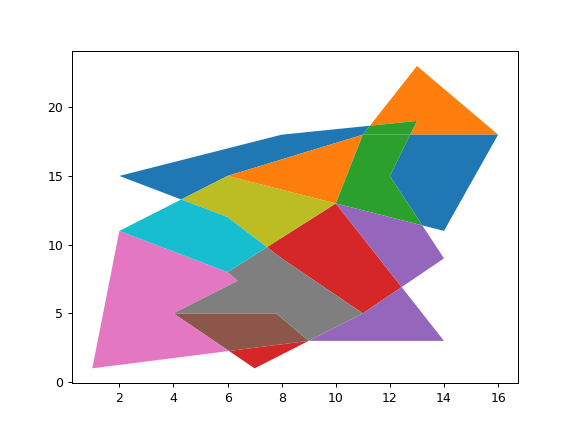

In [48]:
S1 = DCEL(w, w_e)

S1.build_dcel()
plt.close()
for face in S.faces:
    if face.external:
        continue
    e = face.wedge
    x = []
    y = []
    x.append(e.origin.x)
    y.append(e.origin.y)
    while (not e.nexthedge is face.wedge):
        e = e.nexthedge
        x.append(e.origin.x)
        y.append(e.origin.y)    
    plt.fill(x, y)

<IPython.core.display.Javascript object>


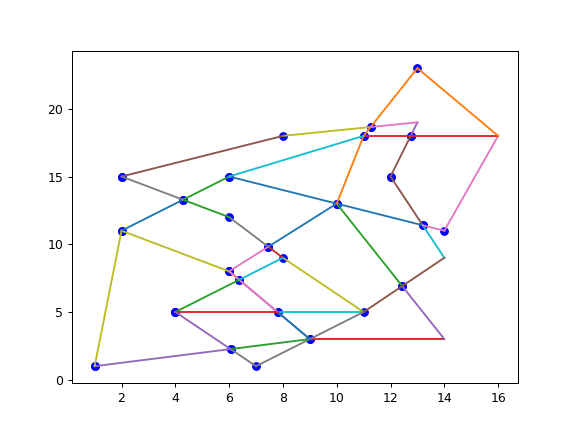

In [49]:
plt.close()
S_lines = []
for edge in S.el:
    v1 = S.vl[edge[0]]
    v2 = S.vl[edge[1]]

    v1 = tuple(v1)
    v2 = tuple(v2)

    S_lines.append([v1, v2])
    plt.scatter(*v1, color='blue')
    
for line in S_lines:
    x = [x[0] for x in line]
    y = [y[1] for y in line]
    plt.plot(x, y)

<IPython.core.display.Javascript object>


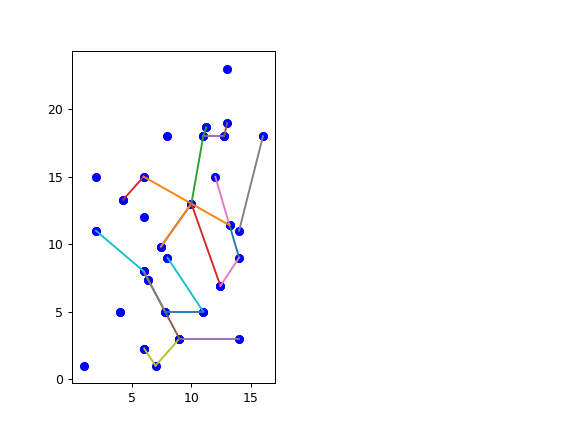

In [50]:
from matplotlib.animation import FuncAnimation


fig = plt.figure()

ax = fig.add_subplot(1,2,1)
S_lines = []
for edge in S.el:
    v1 = S.vl[edge[0]]
    v2 = S.vl[edge[1]]

    v1 = tuple(v1)
    v2 = tuple(v2)

    S_lines.append([v1, v2])
    ax.scatter(*v1, color='blue')
    ax.scatter(*v2, color='blue')
    
    
idx = 0

def animate(i):
    global ax, idx
    if i == 0:
        idx = 0
        
    if idx < len(S_lines):
        ax.plot()
        line = S_lines[idx]
        x = [x[0] for x in line]
        y = [y[1] for y in line]
        plt.plot(x, y)
        idx += 1
    
    
FuncAnimation(fig, animate, frames=100, interval=500)    